# Analysis notebook

This is an analysis notebook. It is mostly used for visualizing waveforms, targets and predictions in an easy fashion.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from benchmark import models
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import matplotlib.pyplot as plt
import numpy as np
import re
import logging

In [3]:
# data = sbd.STEAD(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.ETHZ(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.GEOFON(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
data = sbd.InstanceCountsCombined(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.NEIC(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")

if "split" not in data.metadata.columns:
    logging.warning("No split defined, adding auxiliary split.")
    split = np.array(["train"] * len(data))
    split[int(0.6 * len(data)) : int(0.7 * len(data))] = "dev"
    split[int(0.7 * len(data)) :] = "test"

    data._metadata["split"] = split

dev_data = data.dev()

/vol/home-vol3/wbi/muenchmj/code/seisbench/seisbench/data/instance.py:167: DtypeWarning: Columns (22,23,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  super().__init__([InstanceCounts(**kwargs), InstanceNoise(**kwargs)])


## PhaseNet

In [4]:
# model = models.PhaseNetLit.load_from_checkpoint("weights/stead_phasenet_stead_phasenet/2_2/checkpoints/epoch=91-step=96691.ckpt")
model = models.PhaseNetLit.load_from_checkpoint("weights/ethz_phasenet_ethz_phasenet/0_0/checkpoints/epoch=97-step=8721.ckpt")
# model = models.PhaseNetLit.load_from_checkpoint("weights/geofon_phasenet_geofon_phasenet/0_0/checkpoints/epoch=80-step=12797.ckpt", sigma=50)
# model = models.PhaseNetLit(sigma=50, sample_boundaries=(-1000, None))

In [5]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_augmentations())

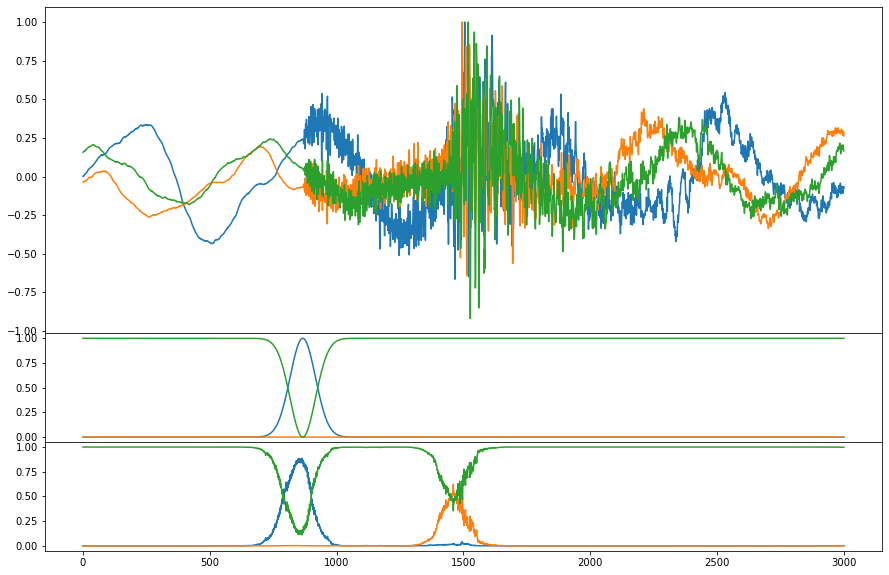

In [51]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

with torch.no_grad():
    pred = model(torch.tensor(x.reshape(1, 3, 3001)))
    pred = pred.cpu().numpy()[0]

axs[0].plot(x.T)
axs[1].plot(y.T)
axs[2].plot(pred.T)

## GPD

In [90]:
# model = models.GPDLit(highpass=2)
# model = models.GPDLit.load_from_checkpoint("weights/stead_gpd_stead_gpd/1_1/checkpoints/epoch=99-step=105099.ckpt")
# model = models.GPDLit.load_from_checkpoint("weights/geofon_gpd_geofon_gpd/1_1/checkpoints/epoch=95-step=15167.ckpt")
# model = models.GPDLit.load_from_checkpoint("weights/ethz_gpd_ethz_gpd/0_0/checkpoints/epoch=89-step=2069.ckpt")
model = models.GPDLit.load_from_checkpoint("weights/instance_gpd_instance_gpd/0_0/checkpoints/epoch=74-step=56774.ckpt")
model.eval();

In [91]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_augmentations())

In [92]:
dev_generator._augmentations[-3].labels

['P', 'S', 'Noise']

[2]
[ 0.00208345  0.00653092  0.9913857 ]


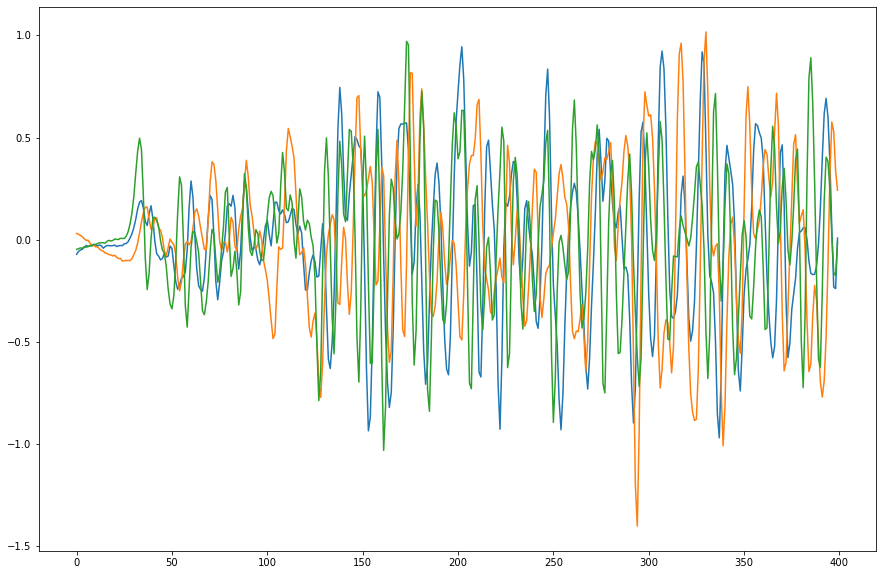

In [93]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"]

fig = plt.figure(figsize=(15, 10))
ax = fig.subplots(1, 1)

with torch.no_grad():
    pred = model(torch.tensor(x.reshape(1, 3, 400)))
    pred = pred.cpu().numpy()[0]

ax.plot(x.T)
print(y)
print(pred)

In [94]:
torch.save(model.model.state_dict(), "/vol/home-vol3/wbi/muenchmj/instance.pt")

## EQTransformer

In [83]:
# model = models.EQTransformerLit(sigma=50, rotate_array=True)
model = models.EQTransformerLit.load_from_checkpoint("weights/stead_eqtransformer_stead_eqtransformer/0_0/checkpoints/epoch=75-step=79875.ckpt")
# model = models.EQTransformerLit.load_from_checkpoint("weights/ethz_eqtransformer_ethz_eqtransformer/0_0/checkpoints/epoch=89-step=2069.ckpt")
# model = models.EQTransformerLit.load_from_checkpoint("weights/neic_eqtransformer_neic_eqtransformer/0_0/checkpoints/epoch=81-step=78227.ckpt")
model.eval();

In [84]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_val_augmentations())
# dev_generator.add_augmentations(model.get_train_augmentations())

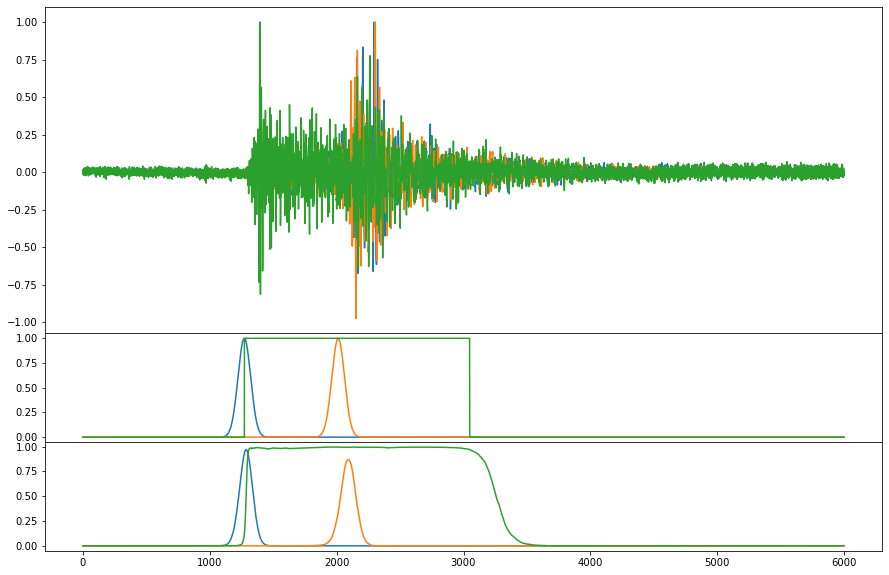

In [89]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"][:2]
detection = sample["detections"][0]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

with torch.no_grad():
    det_pred, p_pred, s_pred = model(torch.tensor(x.reshape(1, 3, 6000)))
    det_pred = det_pred.cpu().numpy()[0]
    p_pred = p_pred.cpu().numpy()[0]
    s_pred = s_pred.cpu().numpy()[0]

axs[0].plot(x.T)
axs[1].plot(y.T)
axs[1].plot(detection)
axs[2].plot(p_pred)
axs[2].plot(s_pred)
axs[2].plot(det_pred)

In [75]:
# torch.save(model.model.state_dict(), "/vol/home-vol3/wbi/muenchmj/stead.pt")

## CRED

In [95]:
# model = models.CREDLit()
model = models.CREDLit.load_from_checkpoint("weights/stead_cred_stead_cred/0_0/checkpoints/epoch=29-step=31529.ckpt")
model.eval();

In [96]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_val_augmentations())

(-0.05, 1.05)

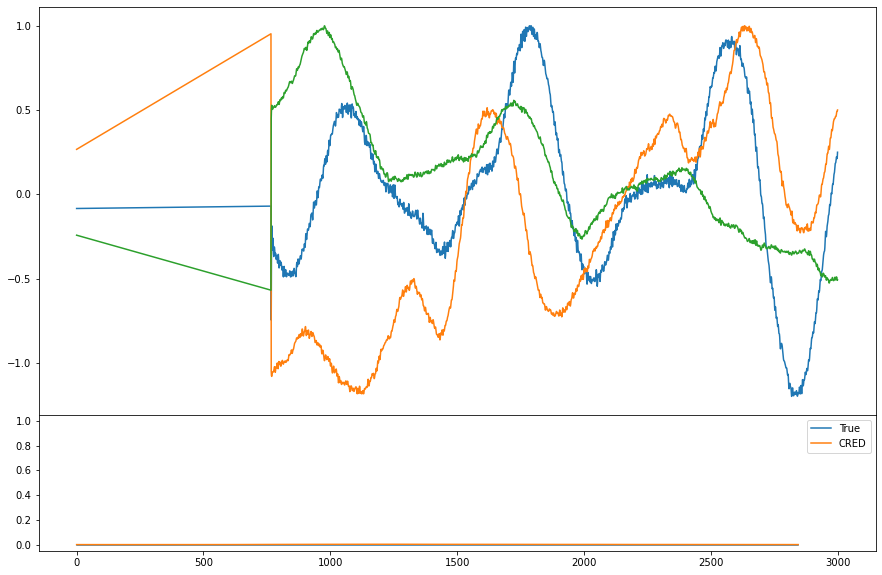

In [100]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"][0]
spec = sample["spec"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1)})

with torch.no_grad():
    pred = model(torch.tensor(spec.reshape(1, 3, 76, 41)))
    pred = pred.cpu().numpy()[0]

axs[0].plot(x.T)
axs[1].plot(158 * np.arange(19), y, label="True")
axs[1].plot(158 * np.arange(19), pred, label="CRED")
axs[1].legend()
axs[1].set_ylim(-0.05, 1.05)